In [2]:
import uproot
import pandas as pd
import mplhep as hep
import numpy as np
import awkward
import ROOT
import scipy.stats as stats #this one used to do fits
import matplotlib.pyplot as plt
import awkward as ak
import MyHelpers as mh
from tqdm import tqdm #this is a fancy feature to make a progress bar as the loop proceed


#to make the plots in CMS style execute this line
plt.style.use([hep.style.ROOT, hep.style.firamath])
plt.style.use(hep.style.CMS)

Welcome to JupyROOT 6.24/00


In [3]:
#Getting files
#Execute this line if running on SWAN, otherwise update the path to the data files:
PATH='/eos/cms/store/user/jjhollar/CERNSummerStudentProject2021/'
#PATH='data'
filename=PATH+'/gammagammaMuMu_FPMC_pT25_14TeV_PU200_NTUPLE_jobs123merge_version4.root'
#load the file content
tree = uproot.open(filename+":myana/mytree")
tree.show()

filename=PATH+'DYMuMu_PU200_NTUPLE_1_version3.root'
bg_tree = uproot.open(filename+":myana/mytree")

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
evt_size             | int32_t                  | AsDtype('>i4')
vtx_size             | int32_t                  | AsDtype('>i4')
vtx_x                | float[]                  | AsJagged(AsDtype('>f4'))
vtx_y                | float[]                  | AsJagged(AsDtype('>f4'))
vtx_z                | float[]                  | AsJagged(AsDtype('>f4'))
vtx_pt2              | float[]                  | AsJagged(AsDtype('>f4'))
vtx4D_size           | int32_t                  | AsDtype('>i4')
vtx4D_x              | float[]                  | AsJagged(AsDtype('>f4'))
vtx4D_y              | float[]                  | AsJagged(AsDtype('>f4'))
vtx4D_z              | float[]                  | AsJagged(AsDtype('>f4'))
vtx4D_t              | float[]                  | AsJagged(AsDtype('>f4'))
vtx4D_terr           | float[]             

In [4]:
#Create signal tree
event_info = tree.arrays(['genvtx_t0']) 
muons = tree.arrays(['pfcand_pt','pfcand_eta','pfcand_phi','pfcand_mass','pfcand_t','pfcand_vz'],'abs(pfcand_pid)==13') 
protons = tree.arrays(['genproton_xi','genproton_pz','genproton_vz','genproton_ispu'], '(genproton_ispu == 0) & (abs(genproton_pz)<6999) & (abs(genproton_pz)>0)')  
vertices = tree.arrays(['vtx4D_t','vtx4D_z','vtx4D_pt2']) 
#(abs(genproton_xi)> 0.0032) & 
#Create background tree
#Compressing the muon data
bg_muons =[]
for batch, report in bg_tree.iterate(['pfcand_pt','pfcand_eta','pfcand_phi','pfcand_mass','pfcand_t','pfcand_vz','pfcand_pid'], step_size=1000, report=True):
    #print(report)
    bg_muons.append(batch[(abs(batch.pfcand_pid)==13) & (batch.pfcand_pt>25)] )
bg_muons=ak.concatenate(bg_muons)

bg_protons = bg_tree.arrays(['genproton_xi','genproton_pz','genproton_vz','genproton_ispu'],'(abs(genproton_pz)<6999) & (abs(genproton_pz)>0)')
bg_event_info = bg_tree.arrays(['genvtx_t0']) 
bg_vertices = bg_tree.arrays(['vtx4D_t','vtx4D_z','vtx4D_pt2'])

In [7]:
sqrt_s = 14000
zpps = 2.34e4 #in cm
c = 29.9792#in cm/ns 

#define data array for signal
sig_data = {}
mh.InitData(sig_data)
#loop over all events for the signal
N = len(muons)
for i in tqdm(range(N)): 
    #find index of two highest pT muons with pT > 25 GeV
    mu=muons[i]
    mu1_idx, mu2_idx = mh.SelMu(mu)            
    #if found less than 2 muons, skip the event:
    if mu1_idx<0 or mu2_idx<0: continue 
    mu1, mu2 = mh.GiveMu(mu, mu1_idx, mu2_idx)
    xi_dimu_plus = ((mu1.Pt()*np.exp(mu1.Rapidity())+mu2.Pt()*np.exp(mu2.Rapidity())) / sqrt_s) 
    xi_dimu_minus =((mu1.Pt()*np.exp(-mu1.Rapidity())+mu2.Pt()*np.exp(-mu2.Rapidity())) / sqrt_s)
    #additional cut
    if((xi_dimu_plus<0.0032) == True & (xi_dimu_minus<0.0032) == True): continue   
    # find two signal protons:
    pr=protons[i]
    # smearing and selecting protons
    pr1_idx, pr2_idx = mh.SelProtons(pr,mu1,mu2, xi_dimu_plus, xi_dimu_minus)
    if pr1_idx<0 or pr2_idx<0: continue
    vx = vertices[i]
    ev = event_info[i]
    #Filling muon and proton events
    mh.Fill_mu(sig_data, mu, mu1, mu2, mu1_idx,mu2_idx)
    mh.Fill_pr(sig_data,pr,pr1_idx,pr2_idx,vx,ev)
    mh.Sig_time(sig_data, ev, pr, pr1_idx, pr2_idx)
    #Add smeared proton times
    mh.Fill_smeared_pr_t(sig_data)
sig = pd.DataFrame(data=sig_data)

#define data array for Background
bg_data = {}
mh.InitData(bg_data)
#loop over all events for the background
n = len(bg_muons)
for i in tqdm(range(n)): 
    #find index of two highest pT muons with pT > 25 GeV
    mu=bg_muons[i]
    mu1_idx, mu2_idx = mh.SelMu(mu)    
    #if found less than 2 muons, skip the event:
    if mu1_idx<0 or mu2_idx<0: continue 
    mu1, mu2 = mh.GiveMu(mu, mu1_idx, mu2_idx)
    xi_dimu_plus = ((mu1.Pt()*np.exp(mu1.Rapidity())+mu2.Pt()*np.exp(mu2.Rapidity())) / sqrt_s) 
    xi_dimu_minus =((mu1.Pt()*np.exp(-mu1.Rapidity())+mu2.Pt()*np.exp(-mu2.Rapidity())) / sqrt_s)
    #additional cut
    if((xi_dimu_plus<0.0032) == True & (xi_dimu_minus<0.0032) == True): continue 
    # find two signal protons:
    pr=bg_protons[i]
    # smearing and selecting protons
    pr1_idx, pr2_idx = mh.SelProtons(pr,mu1,mu2, xi_dimu_plus, xi_dimu_minus)
    #if pr1_idx<0 or pr2_idx<0: continue
    vx = bg_vertices[i]
    ev = bg_event_info[i]
    #Filling muon and proton events
    mh.Fill_mu(bg_data,mu, mu1, mu2, mu1_idx,mu2_idx)
    mh.Fill_pr(bg_data,pr,pr1_idx,pr2_idx,vx,ev) 
    mh.Bg_time(bg_data, pr, pr1_idx, pr2_idx)
    #Add smeared proton times
    mh.Fill_smeared_pr_t(bg_data)
bg = pd.DataFrame(data=bg_data)


100%|██████████| 15296/15296 [01:36<00:00, 157.82it/s]


107


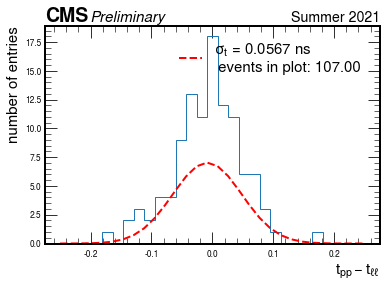

In [11]:
#Vertex position in time: (tp1 + tp2)*c = 2 zpps + t(mu)*c
zpps = 2.34e4 #in cm
c = 29.9792#in cm/ns

mask_muon1_measured_time = (sig['mu1_t']>-80) & (sig['mu2_t']>-80)

masked_analysis=sig[mask_muon1_measured_time]
tmu =  ( masked_analysis['mu1_t'].values  + masked_analysis['mu2_t'].values )/2

tpp =  (( masked_analysis['pr1_t'].values + masked_analysis['pr2_t'].values ) - 2*zpps/c)/2
#20
#tpp =  (( masked_analysis['pr1_20_t'].values + masked_analysis['pr2_20_t'].values ) - 2*zpps/c)/2
#60
#tpp =  (( masked_analysis['pr1_60_t'].values + masked_analysis['pr2_60_t'].values ) - 2*zpps/c)/2
#70
tpp =  (( masked_analysis['pr1_50_t'].values + masked_analysis['pr2_50_t'].values ) - 2*zpps/c)/2

data = (tpp-tmu)
#print((data)) for non,20,60 equally good choice !
#data = data[~np.isnan(data) & ~np.isneginf(data)]

data = data[~np.isnan(data) & ~np.isneginf(data)]
print(len(data))
bins = np.linspace(-0.25,0.25,30)
f, ax = plt.subplots()
plt.hist(data,bins, histtype='step')

#fit to gaussian (to avoid bias from outliers restrict the fitted area)
(mu_t, sigma_t) = stats.norm.fit(data)
x=bins
y=stats.norm.pdf(x, mu_t, sigma_t)
ax.plot(x, y, 'r--', linewidth=2,label='$\sigma_{t}$ = %4.4f ns \n events in plot: %2.2f '%((sigma_t), (len(data))))
#print(y)
#print(x)
hep.cms.label(llabel="Preliminary", rlabel="Summer 2021", ax=ax,fontsize = 15)
ax.set(xlabel=r'$t_{pp} - t_{\ell\ell}$', ylabel='number of entries')
ax.legend(fontsize=15)
ax.xaxis.label.set_size(15)
ax.yaxis.label.set_size(15)
plt.savefig('Timing/fit_vertex_t_50.png',bbox_inches='tight')

acceptance rate from background cut:
0.2263959390862944
acceptance rate from signal cut:
0.788235294117647


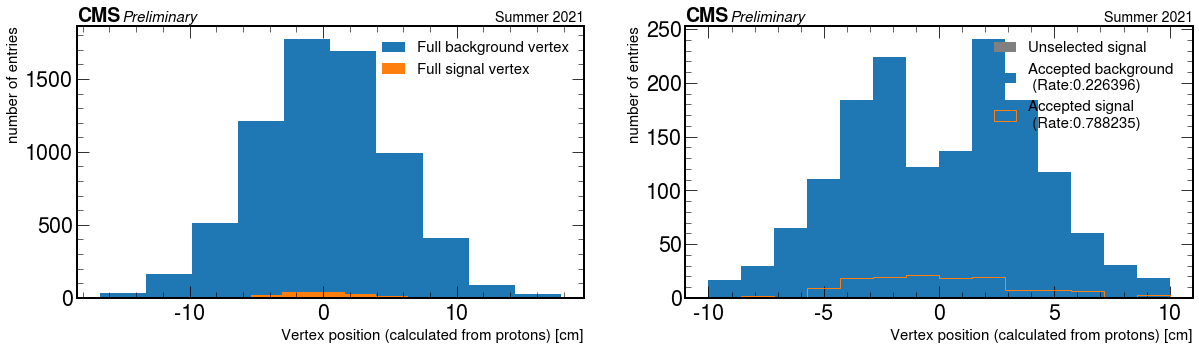

In [134]:
zpps = 2.34e4 #in cm
c = 29.9792#in cm/ns
#Background
b_z = []
b_pp_vz = - (bg['pr1_t'] - bg['pr2_t'])*c/2 
b_mu = (bg['mu1_vz'] + bg['mu2_vz'])/2
b_vz_4D = bg['pr_vtx_z'].values
data_bz = abs(b_pp_vz - b_vz_4D)

for i in range(0,len(data_bz)):
    if data_bz[i] < abs(2*sigma_vz*b_vz_4D[i]):
            b_z = np.append(b_z,b_pp_vz[i])
acc_bg = len(b_z)/len(data_bz)

print('acceptance rate from background cut:')
print(acc_bg)

#Signal
s_z = []
p1_t = sig['pr1_t']
p2_t = sig['pr2_t'] 
s_pp_vz = - (p1_t - p2_t)*c/2 
s_vz_4D = sig['pr_vtx_z']
data_sz = abs(s_pp_vz - s_vz_4D)

for i in range(0,len(data_sz)):
    if data_sz[i] < abs(2*sigma_vz*s_vz_4D[i]):
            s_z = np.append(s_z, s_pp_vz[i])
acc_sig =len(s_z)/len(data_sz)

print('acceptance rate from signal cut:')
print(acc_sig)

#Plots
f, ax = plt.subplots(1,2,figsize=(20,5),sharey=False)

ax[0].hist(b_pp_vz, label = 'Full background vertex')
ax[0].hist(s_pp_vz, label='Full signal vertex')
ax[0].set(xlabel=r'Vertex position (calculated from protons) [cm]', ylabel='number of entries')

bins = np.linspace(-10,10,15)
ax[1].hist(s_pp_vz,bins, color = "grey",label='Unselected signal')
ax[1].hist(b_z, bins, label='Accepted background \n (Rate:%6.6f)'%acc_bg)
ax[1].hist(s_z,bins, histtype = 'step', label='Accepted signal \n (Rate:%6.6f)'%acc_sig)
ax[1].set(xlabel=r'Vertex position (calculated from protons) [cm]', ylabel='number of entries')

for i in range(2):    
    hep.cms.label(llabel="Preliminary", rlabel="Summer 2021", ax=ax[i], fontsize = 15)
    ax[i].legend(fontsize=15)
    ax[i].xaxis.label.set_size(15)
    ax[i].yaxis.label.set_size(15)
plt.savefig('Timing/surviving_protons_vz', bbox_inches='tight')

0.756082646502598
0.12336601947853174


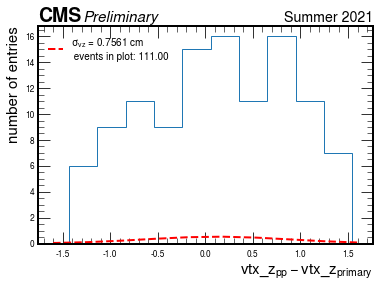

In [17]:
zpps = 2.34e4 #in cm
c = 29.9792#in cm/ns

#pp_vz = - (sig['pr1_t'] - sig['pr2_t'])*c/2 
#20
#pp_vz = - (sig['pr1_20_t'] - sig['pr2_20_t'])*c/2 
#50
pp_vz = - (sig['pr1_50_t'].values - sig['pr2_50_t'].values)*c/2
vz_4D = sig['pr_vtx_z'].values

data = (pp_vz - vz_4D)

#data = data[~np.isnan(data) & (abs(data) < 0.025) ]
#20
data = data[~np.isnan(data) & (abs(data) < 1.6) ]
#60
#data = data[~np.isnan(data) & (abs(data) < 5) ]
#print(data)

bins = np.linspace(-1.6,1.6,10)
f, ax = plt.subplots()
plt.hist(data,histtype='step')
#print(data)  norm.pdf(x, loc, scale)
#fit to gaussian (to avoid bias from outliers restrict the fitted area):  = analysis['s_mpp']-analysis['s_mll'] <
(mu_vz, sigma_vz) = stats.norm.fit(data)
print(sigma_vz)
print(mu_vz)
#bins = np.linspace(-5,5,103)
x=bins
y=stats.norm.pdf(x, mu_vz, sigma_vz)
#print(y)
ax.plot(x, y, 'r--', linewidth=2,label='$\sigma_{vz}$ = %4.4f cm\n events in plot: %2.2f '%((sigma_vz), (len(data))))

hep.cms.label(llabel="Preliminary", rlabel="Summer 2021", ax=ax,fontsize=15)
ax.set(xlabel=r'$vtx\_z_{pp} - vtx\_z_{primary}}$', ylabel='number of entries')
ax.legend(loc='upper left',fontsize=10)
ax.xaxis.label.set_size(15)
ax.yaxis.label.set_size(15)

plt.savefig('Timing/fit_vz_ratio_50.png',bbox_inches='tight')

In [81]:
#timing
#variables
zpps = 2.34e4 #in cm
c = 29.9792#in cm/ns

#    data['pr1_20_t'] 
#    data['pr2_20_t']
#    data['pr1_60_t'] 
#    data['pr2_60_t'] 
#    data['pr1_t']
#    data['pr2_t'] 

#background
mask_measured_time = (bg['mu1_t'] >-80) & (bg['mu2_t']>-80)
b_masked_analysis=bg[mask_measured_time]

b_tmu = (b_masked_analysis['mu1_t'].values +b_masked_analysis['mu2_t'].values )/2 
b_tpp = ( (b_masked_analysis['pr1_t'].values + b_masked_analysis['pr2_t'].values) - 2*zpps/c)/2

data_bt =[]
data_bt = abs(b_tpp - b_tmu)
b_t = []
for i in range(0,len(data_bt)):
    if (data_bt[i] < abs(2*sigma_t)):
        b_t = np.append(b_t,b_tpp[i])
acc_bg = len(b_t)/len(data_bt)

print('acceptance rate from background cut:')
print(acc_bg)

#signal
mask_muon1_measured_time = (sig['mu1_t']>-80) & (sig['mu2_t']>-80)
masked_analysis=sig[mask_muon1_measured_time]

s_tmu = ( masked_analysis['mu1_t'].values  +  masked_analysis['mu2_t'].values)/2
s_tpp =(( masked_analysis['pr1_t'].values + masked_analysis['pr2_t'].values) - 2*zpps/c)/2

data_st = []
data_st = abs(s_tpp - s_tmu)
s_t = []
for i in range(0,len(data_st)):
    if data_st[i] < abs(2*sigma_t):
            s_t = np.append(s_t, s_tpp[i])
acc_sig =len(s_t)/len(data_st)

print('acceptance rate from signal cut:')
print(acc_sig)

acceptance rate from background cut:
0.2823878069432684
acceptance rate from signal cut:
0.9444444444444444


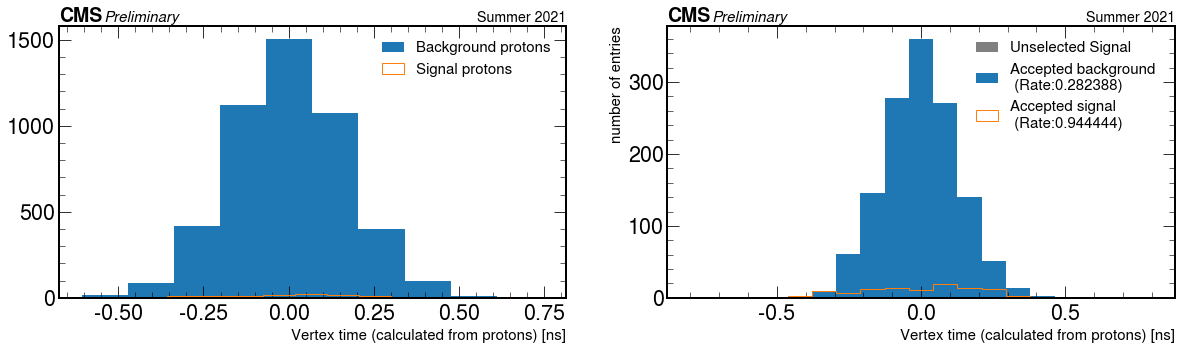

In [82]:
f, ax = plt.subplots(1,2,figsize=(20,5),sharey=False)
bins = np.linspace(-8,8,16)
ax[0].hist(b_tpp, label = 'Background protons')
ax[0].hist(s_tpp,histtype='step', label='Signal protons')
ax[0].set(xlabel=r'Vertex time (calculated from protons) [ns]')
#ax[0].set_xlim(-20,20)
bins=np.linspace(-0.8,0.8,20)
ax[1].hist(s_tpp,bins, color= 'grey', label = 'Unselected Signal')
ax[1].hist(b_t, bins,label='Accepted background \n (Rate:%6.6f)'%acc_bg)
ax[1].hist(s_t,bins, histtype='step',label='Accepted signal \n (Rate:%6.6f)'%acc_sig)
ax[1].set(xlabel=r'Vertex time (calculated from protons) [ns]', ylabel='number of entries')

for i in range(2):    
    hep.cms.label(llabel="Preliminary", rlabel="Summer 2021", ax=ax[i], fontsize = 15)
    ax[i].legend(fontsize=15)
    ax[i].xaxis.label.set_size(15)
    ax[i].yaxis.label.set_size(15)
plt.savefig('Timing/surviving_protons_t', bbox_inches='tight')

acceptance rate from background cut:
0.000846740050804403
acceptance rate from signal cut:
0.6666666666666666


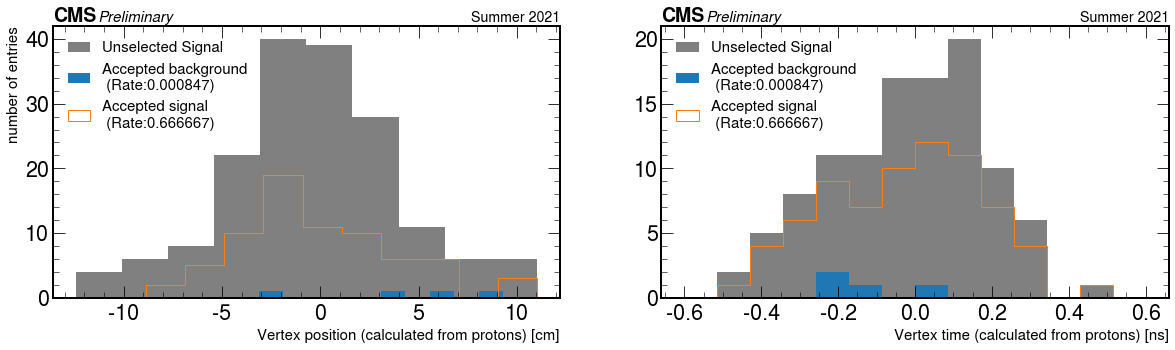

In [83]:
#combined timing and spatial vertex cuts:
b_z = []
b_t = []
for i in range(0,len(data_bt)):
    if data_bt[i] < abs(2*sigma_t):
        if data_bz[i] < abs(2*sigma_vz*b_vz_4D[i]):
                b_z = np.append(b_z,b_pp_vz[i])
                b_t = np.append(b_t,b_tpp[i])
acc_bg = len(b_t)/len(data_bt)
print('acceptance rate from background cut:')
print(acc_bg)

s_z = []
s_t = []
for i in range(0,len(data_st)):
    if data_st[i] < abs(2*sigma_t):
        if data_sz[i] < abs(2*sigma_vz*s_vz_4D[i]):
                s_z = np.append(s_z, s_pp_vz[i])
                s_t = np.append(s_t, s_tpp[i])
acc_sig =len(s_t)/len(data_st)
print('acceptance rate from signal cut:')
print(acc_sig)

f, ax = plt.subplots(1,2,figsize=(20,5),sharey=False)
#bins = np.linspace(-4,4,10)
ax[0].hist(s_pp_vz, color= 'grey', label = 'Unselected Signal')
ax[0].hist(b_z, label='Accepted background \n (Rate:%6.6f)'%acc_bg)
ax[0].hist(s_z, histtype='step',label='Accepted signal \n (Rate:%6.6f)'%acc_sig)
ax[0].set(xlabel=r'Vertex position (calculated from protons) [cm]', ylabel='number of entries')
bins = np.linspace(-0.6,0.6,15)

#ax[1].hist(bg_anal['mpp'],histtype='step',label='Background protons')

ax[1].hist(s_tpp,bins, color= 'grey', label = 'Unselected Signal')
ax[1].hist(b_t,bins, label='Accepted background \n (Rate:%6.6f)'%acc_bg)
ax[1].hist(s_t,bins,histtype='step',label='Accepted signal \n (Rate:%6.6f)'%acc_sig)
ax[1].set(xlabel=r'Vertex time (calculated from protons) [ns]')

for i in range(2):
    hep.cms.label(llabel="Preliminary", rlabel="Summer 2021", ax=ax[i], fontsize = 15)
    ax[i].legend(fontsize=15)
    ax[i].xaxis.label.set_size(15)
    ax[i].yaxis.label.set_size(15)
plt.savefig('Timing/surviving_protons_tvz', bbox_inches='tight')

In [163]:
mask_muon1_measured_time = sig['mu1_t']>-80
mask_muon2_measured_time = sig['mu2_t']>-80

In [164]:
recontsructed_time_resolution1 = sig[mask_muon1_measured_time]['mu1_t'].values - sig[mask_muon1_measured_time]['evt_t0'].values
recontsructed_time_resolution2 = sig[mask_muon2_measured_time]['mu2_t'].values - sig[mask_muon2_measured_time]['evt_t0'].values
recontsructed_time_resolution = np.concatenate([recontsructed_time_resolution1,recontsructed_time_resolution2]) #add two arrays together

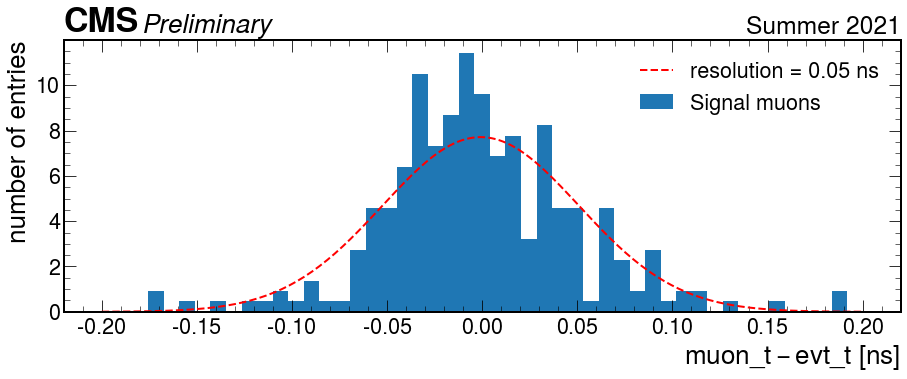

In [167]:
f, ax = plt.subplots(figsize=(15,5))
ax.hist(recontsructed_time_resolution, bins=np.linspace(-0.2,0.2,50),density=True,label='Signal muons')
ax.set(xlabel=r'$ muon\_t - evt\_t$ [ns]', ylabel='number of entries')

#fit to gaussian (to avoid bias from outliers restrict the fitted area):
(mu, sigma) = stats.norm.fit(recontsructed_time_resolution[(recontsructed_time_resolution<0.2) & (recontsructed_time_resolution>-0.2)])
x=np.linspace(-0.2,0.2,200)
y=stats.norm.pdf(x, mu, sigma)
ax.plot(x, y, 'r--', linewidth=2,label='resolution = %2.2f ns'%sigma)

hep.cms.label(llabel="Preliminary", rlabel="Summer 2021", ax=ax)
ax.legend()
plt.savefig('Timing/MTD_resolution_evt.png',bbox_inches='tight')

In [168]:
recontsructed_time_resolution1 = sig[mask_muon1_measured_time]['mu1_t'].values - sig[mask_muon1_measured_time]['pr_vtx_t'].values
recontsructed_time_resolution2 = sig[mask_muon2_measured_time]['mu2_t'].values - sig[mask_muon2_measured_time]['pr_vtx_t'].values
recontsructed_time_resolution = np.concatenate([recontsructed_time_resolution1,recontsructed_time_resolution2]) #add two arrays together

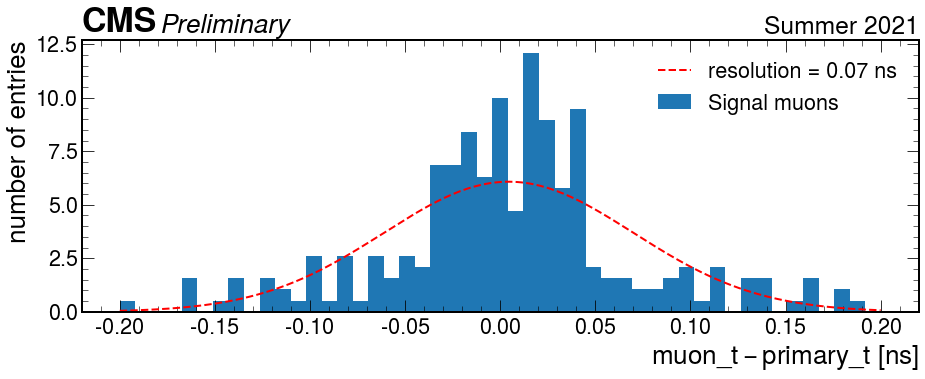

In [171]:

f, ax = plt.subplots(figsize=(15,5))
ax.hist(recontsructed_time_resolution, bins=np.linspace(-0.2,0.2,50),density=True,label='Signal muons')
ax.set(xlabel=r'$muon\_t - primary\_t$ [ns]', ylabel='number of entries')

#fit to gaussian (to avoid bias from outliers restrict the fitted area):
(mu, sigma) = stats.norm.fit(recontsructed_time_resolution[(recontsructed_time_resolution<0.2) & (recontsructed_time_resolution>-0.2)])
x=np.linspace(-0.2,0.2,200)
y=stats.norm.pdf(x, mu, sigma)
ax.plot(x, y, 'r--', linewidth=2,label='resolution = %2.2f ns'%sigma)

hep.cms.label(llabel="Preliminary", rlabel="Summer 2021", ax=ax)
ax.legend()
plt.savefig('Timing/MTD_resolution_4D.png',bbox_inches='tight')

In [ ]:
val = sig[mask_muon1_measured_time]['evt_t0'].values - sig[mask_muon1_measured_time]['pr_vtx_t'].values
bins = np.linspace(-0.25,0.25,40)
#print(val)
f, ax = plt.subplots(figsize=(15,5))
plt.hist(val, bins,label='Signal muons')

(mu, sigma) = stats.norm.fit(val)
x=bins
y=stats.norm.pdf(x, mu, sigma)
ax.plot(x, y, 'r--', linewidth=2,label='resolution = %2.2f ns'%sigma)

hep.cms.label(llabel="Preliminary", rlabel="Summer 2021", ax=ax)
ax.legend(); 
ax.set(xlabel=r'evt\_t - primary\_t [ns]', ylabel='number of entries')
plt.savefig('Timing/evt_minus_4Dt.png',bbox_inches='tight')

In [42]:
mask_muon1_measured_time = bg['mu1_t']>-80
mask_muon2_measured_time = bg['mu2_t']>-80

In [43]:
recontsructed_time_resolution1 = bg[mask_muon1_measured_time]['mu1_t'].values - bg[mask_muon1_measured_time]['evt_t0'].values
recontsructed_time_resolution2 = bg[mask_muon2_measured_time]['mu2_t'].values - bg[mask_muon2_measured_time]['evt_t0'].values
recontsructed_time_resolution = np.concatenate([recontsructed_time_resolution1,recontsructed_time_resolution2]) #add two arrays together

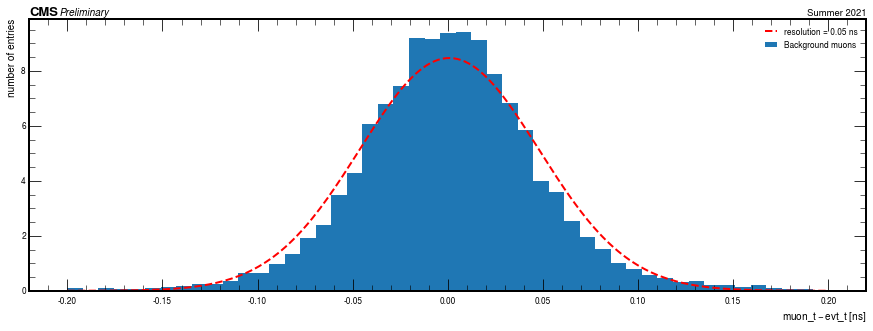

In [44]:
f, ax = plt.subplots(figsize=(15,5))
ax.hist(recontsructed_time_resolution, bins=np.linspace(-0.2,0.2,50),density=True,label='Background muons')
ax.set(xlabel=r'$ muon\_t - evt\_t$ [ns]', ylabel='number of entries')

#fit to gaussian (to avoid bias from outliers restrict the fitted area):
(mu, sigma) = stats.norm.fit(recontsructed_time_resolution[(recontsructed_time_resolution<0.2) & (recontsructed_time_resolution>-0.2)])
x=np.linspace(-0.2,0.2,200)
y=stats.norm.pdf(x, mu, sigma)
ax.plot(x, y, 'r--', linewidth=2,label='resolution = %2.2f ns'%sigma)

hep.cms.label(llabel="Preliminary", rlabel="Summer 2021", ax=ax)
ax.legend()
plt.savefig('Timing/MTD_resolution_evt_bg.png',bbox_inches='tight')

In [45]:
recontsructed_time_resolution1 = bg[mask_muon1_measured_time]['mu1_t'].values - bg[mask_muon1_measured_time]['pr_vtx_t'].values
recontsructed_time_resolution2 = bg[mask_muon2_measured_time]['mu2_t'].values - bg[mask_muon2_measured_time]['pr_vtx_t'].values
recontsructed_time_resolution = np.concatenate([recontsructed_time_resolution1,recontsructed_time_resolution2]) #add two arrays together

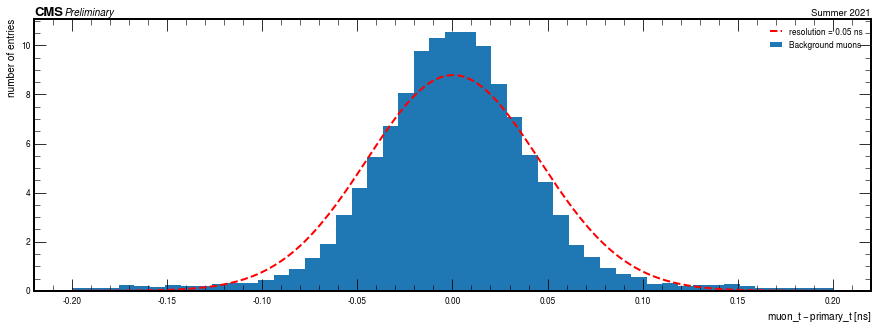

In [46]:
f, ax = plt.subplots(figsize=(15,5))
ax.hist(recontsructed_time_resolution, bins=np.linspace(-0.2,0.2,50),density=True,label='Background muons')
ax.set(xlabel=r'$muon\_t - primary\_t$ [ns]', ylabel='number of entries')

#fit to gaussian (to avoid bias from outliers restrict the fitted area):
(mu, sigma) = stats.norm.fit(recontsructed_time_resolution[(recontsructed_time_resolution<0.2) & (recontsructed_time_resolution>-0.2)])
x=np.linspace(-0.2,0.2,200)
y=stats.norm.pdf(x, mu, sigma)
ax.plot(x, y, 'r--', linewidth=2,label='resolution = %2.2f ns'%sigma)

hep.cms.label(llabel="Preliminary", rlabel="Summer 2021", ax=ax)
ax.legend()
plt.savefig('Timing/MTD_resolution_4D_bg.png',bbox_inches='tight')

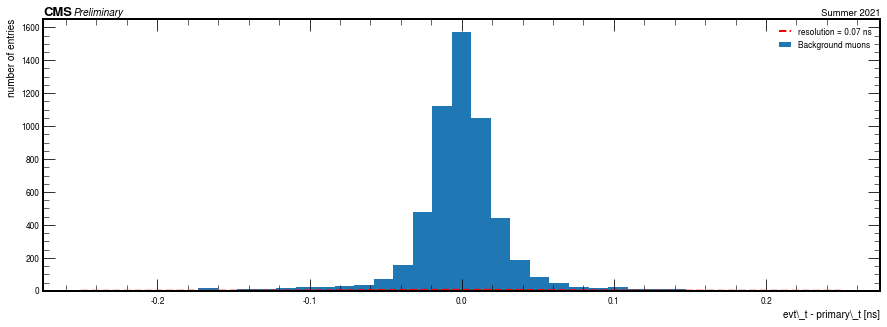

In [48]:
val = bg[mask_muon1_measured_time]['evt_t0'].values - bg[mask_muon1_measured_time]['pr_vtx_t'].values
bins = np.linspace(-0.25,0.25,40)
#print(val)
f, ax = plt.subplots(figsize=(15,5))
plt.hist(val, bins,label='Background muons')

(mu, sigma) = stats.norm.fit(val)
x=bins
y=stats.norm.pdf(x, mu, sigma)
ax.plot(x, y, 'r--', linewidth=2,label='resolution = %2.2f ns'%sigma)

hep.cms.label(llabel="Preliminary", rlabel="Summer 2021", ax=ax)
ax.legend(); 
ax.set(xlabel=r'evt\_t - primary\_t [ns]', ylabel='number of entries')
plt.savefig('Timing/evt_minus_4Dt_bg.png',bbox_inches='tight')

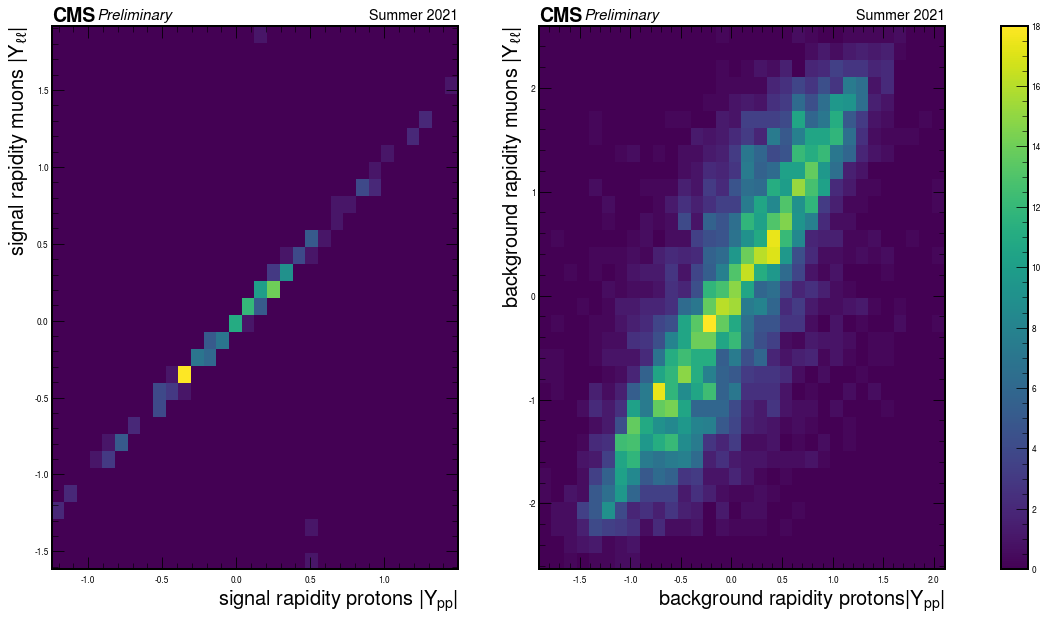

In [211]:

fig, axes = plt.subplots(1,2,figsize=(20,10) )

h = axes[0].hist2d(sig['ypp'].values, sig['yll'].values, bins=(32,32) , cmap='viridis')
axes[0].set(xlabel=r'signal rapidity protons $|Y_{pp}|$', ylabel=r'signal rapidity muons $|Y_{\ell \ell}|$')

axes[1].hist2d(bg['ypp'], bg['yll'], bins=(32,32), cmap='viridis')
axes[1].set(xlabel=r'background rapidity protons$ |Y_{pp}|$', ylabel=r'background rapidity muons $|Y_{\ell \ell}|$')
#axes[1].set_ylim(-2,0.4)
fig.colorbar(h[3], ax=axes)

for i in range(2): 
    hep.cms.label(llabel="Preliminary", rlabel="Summer 2021", ax=axes[i], fontsize = 15)
    axes[i].xaxis.label.set_size(20)
    axes[i].yaxis.label.set_size(20)
plt.savefig('Week4/eta_corr_random.png')

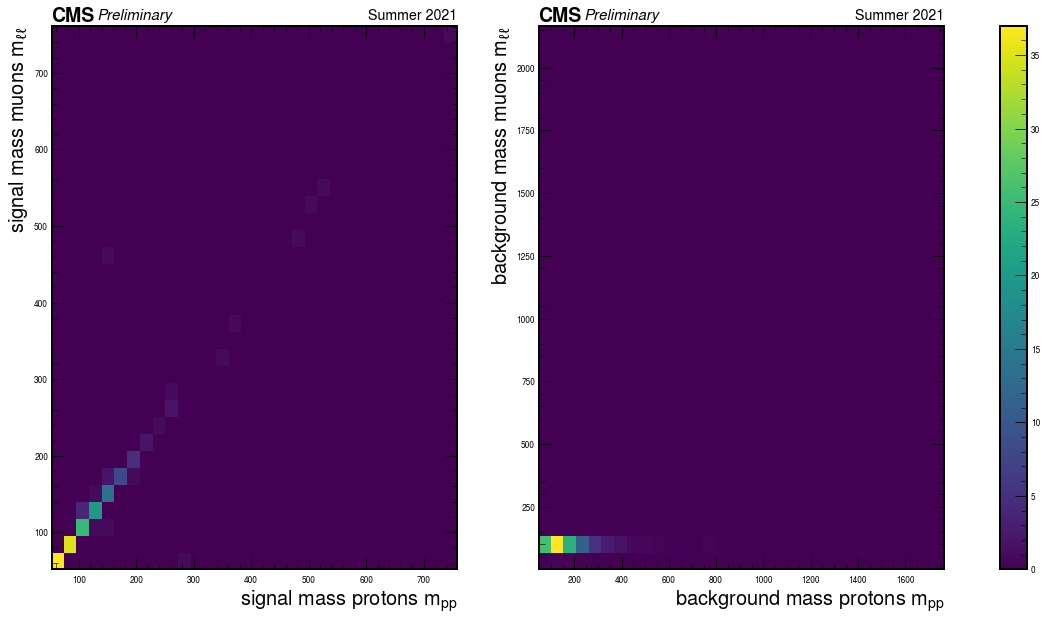

In [216]:

fig, axes = plt.subplots(1,2,figsize=(20,10) )

h = axes[0].hist2d(sig['mpp'].values, sig['mll'].values, bins=(32,32) , cmap='viridis')
axes[0].set(xlabel=r'signal mass protons $m_{pp}$', ylabel=r'signal mass muons $m_{\ell \ell}$')

axes[1].hist2d(bg['mpp'], bg['mll'], bins=(32,32), cmap='viridis')
axes[1].set(xlabel=r'background mass protons $ m_{pp}$', ylabel=r'background mass muons $ m_{\ell \ell}$')
#axes[1].set_ylim(-2,0.4)
fig.colorbar(h[3], ax=axes)

for i in range(2): 
    hep.cms.label(llabel="Preliminary", rlabel="Summer 2021", ax=axes[i], fontsize = 15)
    axes[i].xaxis.label.set_size(20)
    axes[i].yaxis.label.set_size(20)
plt.savefig('Week4/m_corr.png')